In [1]:
import pennylane as qml

### Encoding Method

In [32]:
j=2
eps=1.0
g=0.5
V=0.5

In [33]:
# Encode indices with the specified rule
def encode_indices(p, m, j):
    if p not in {1, -1}:
        raise ValueError("p must be either 1 or -1.")
    if m == 0 or not (-j <= m <= j):
        raise ValueError(f"m must be in the range +/-1, +/-2, ..., +/-j, but got m={m} and j={j}.")

    if m > 0:
        k = j - m
    else:
        k = j - m - 1 # shift by one because m can't be 0

    if p == -1:
        k += 2 * j

    return k

# Decode a single index back into multi-indices (p, m, j)
def decode_index(k, j):
    if k < 0 or k >= 4 * j:
        raise ValueError(f"k={k} is out of valid range for j={j}.")

    # Determine p based on the range of k
    p = 1 if k < 2 * j else -1

    # Adjust k for p = -1
    k_adjusted = k if p == 1 else k - 2 * j

    # Determine m
    m = j - k_adjusted if k_adjusted < j else j - (k_adjusted + 1) # inverse of the encoding line in encode_indices

    return p, m

### Test Encoding

In [34]:

for p in [1, -1]:
    for m in range(j, -j-1, -1):
        if m == 0: continue

        k = encode_indices(p, m, j)
        p_, m_ = decode_index(k, j)

        print("Original indices: p={}, m={}".format(p, m, j))
        print("Decoded indices:  p={}, m={}".format(p_, m_))
        print("Encoded index:    k={}".format(k))
        print()

Original indices: p=1, m=2
Decoded indices:  p=1, m=2
Encoded index:    k=0

Original indices: p=1, m=1
Decoded indices:  p=1, m=1
Encoded index:    k=1

Original indices: p=1, m=-1
Decoded indices:  p=1, m=-1
Encoded index:    k=2

Original indices: p=1, m=-2
Decoded indices:  p=1, m=-2
Encoded index:    k=3

Original indices: p=-1, m=2
Decoded indices:  p=-1, m=2
Encoded index:    k=4

Original indices: p=-1, m=1
Decoded indices:  p=-1, m=1
Encoded index:    k=5

Original indices: p=-1, m=-1
Decoded indices:  p=-1, m=-1
Encoded index:    k=6

Original indices: p=-1, m=-2
Decoded indices:  p=-1, m=-2
Encoded index:    k=7



### Hamiltonian

In [35]:
# Annihilation operator
def C(p, m, j):
    return qml.FermiA(encode_indices(p, m, j))

# Creation operator
def C_dag(p, m, j):
    return qml.FermiC(encode_indices(p, m, j))

# Agassi Hamiltonian
def agassi_hamiltonian(j, eps, g, V):
    
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms
    
    def A_dag(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res
    
    def A(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    A_terms = 0
    for p in [-1, 1]:
        for p_ in [-1, 1]:
            A_terms += A_dag(p, j) * A(p_, j)
    
    
    # Hamiltonian
    H = eps * J0 - g * A_terms - V/2 * (J_plus * J_plus + J_minus * J_minus)
    
    return H

H_sec = agassi_hamiltonian(j, eps, g, V)
print("Second quantization Hamiltonian:")
print(H_sec)
print()

H_ps = qml.jordan_wigner(H_sec, ps=True)
# H = H.simplify()
print("Jordan-Wigner Hamiltonian:")
print(H_ps)
print()


Second quantization Hamiltonian:
-0.25 * a⁺(0) a(4) a⁺(0) a(4)
+ -0.0 * a⁺(0) a(4)
+ -0.25 * a⁺(0) a(4) a⁺(1) a(5)
+ -0.25 * a⁺(0) a(4) a⁺(2) a(6)
+ -0.25 * a⁺(0) a(4) a⁺(3) a(7)
+ 0.0 * I
+ -0.0 * a⁺(1) a(5)
+ -0.0 * a⁺(2) a(6)
+ -0.0 * a⁺(3) a(7)
+ -0.25 * a⁺(1) a(5) a⁺(0) a(4)
+ -0.25 * a⁺(1) a(5) a⁺(1) a(5)
+ -0.25 * a⁺(1) a(5) a⁺(2) a(6)
+ -0.25 * a⁺(1) a(5) a⁺(3) a(7)
+ -0.25 * a⁺(2) a(6) a⁺(0) a(4)
+ -0.25 * a⁺(2) a(6) a⁺(1) a(5)
+ -0.25 * a⁺(2) a(6) a⁺(2) a(6)
+ -0.25 * a⁺(2) a(6) a⁺(3) a(7)
+ -0.25 * a⁺(3) a(7) a⁺(0) a(4)
+ -0.25 * a⁺(3) a(7) a⁺(1) a(5)
+ -0.25 * a⁺(3) a(7) a⁺(2) a(6)
+ -0.25 * a⁺(3) a(7) a⁺(3) a(7)
+ -0.25 * a⁺(4) a(0) a⁺(4) a(0)
+ -0.0 * a⁺(4) a(0)
+ -0.25 * a⁺(4) a(0) a⁺(5) a(1)
+ -0.25 * a⁺(4) a(0) a⁺(6) a(2)
+ -0.25 * a⁺(4) a(0) a⁺(7) a(3)
+ -0.0 * a⁺(5) a(1)
+ -0.0 * a⁺(6) a(2)
+ -0.0 * a⁺(7) a(3)
+ -0.25 * a⁺(5) a(1) a⁺(4) a(0)
+ -0.25 * a⁺(5) a(1) a⁺(5) a(1)
+ -0.25 * a⁺(5) a(1) a⁺(6) a(2)
+ -0.25 * a⁺(5) a(1) a⁺(7) a(3)
+ -0.25 * a⁺(6) a(2) a⁺(4) a(0)

In [6]:


# Agassi Hamiltonian paired
def agassi_hamiltonian1(j, eps, g, V):
    
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms
    
    def A_dag(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res
    
    def A(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    
    
    A_terms_Paired = 0
    for p in [-1, 1]:
        A_terms_Paired += A_dag(p, j) * A(p, j)

    A_terms_Unpaired = 0
    for p in [-1, 1]:
        A_terms_Unpaired += A_dag(p, j) * A(-p, j)

    # Hamiltonian
    H_1 = eps * J0 - g * A_terms_Paired
    H_2 = - g * A_terms_Unpaired - V/2 * (J_plus * J_plus + J_minus * J_minus)

    H_ps1 = qml.jordan_wigner(H_1, ps=True)
    H_ps2 = qml.jordan_wigner(H_2, ps=True)

    return H_ps1, H_ps2


In [7]:
def test_commutativity(H_1, H_2):
    
    split_sentences1 = {}

    for pauli_word in H_1.items():
       
        # If this number is not already in the dictionary, initialize a new PauliSentence
        if pauli_word not in split_sentences1:
            split_sentences1[pauli_word] = qml.pauli.PauliSentence()

    from itertools import combinations
    from pennylane.pauli import PauliSentence

    # Iterate over all pairs of PauliSentences from split_result and test commutativity
    for (key1, ps1), (key2, ps2) in combinations(split_sentences1.items(), 2):
        # Compute their commutator
        comm = ps1.commutator(ps2)

        # Check if they commute
        if len(comm) == 0:
            print(f"{key1} and {key2} commute.")
        else:
            print(f"{key1} and {key2} do NOT commute.")


    split_sentences2 = {}

    for pauli_word in H_2.items():
       
        # If this number is not already in the dictionary, initialize a new PauliSentence
        if pauli_word not in split_sentences2:
            split_sentences1[pauli_word] = qml.pauli.PauliSentence()

    from itertools import combinations
    from pennylane.pauli import PauliSentence

    # Iterate over all pairs of PauliSentences from split_result and test commutativity
    for (key1, ps1), (key2, ps2) in combinations(split_sentences2.items(), 2):
        # Compute their commutator
        comm = ps1.commutator(ps2)

        # Check if they commute
        if len(comm) == 0:
            print(f"{key1} and {key2} commute.")
        else:
            print(f"{key1} and {key2} do NOT commute.")


In [8]:
H_1, H_2 = agassi_hamiltonian1(j, eps, g, V)
test_commutativity(H_1, H_2)


(I, (-0.25+0j)) and (Z(2), (0.375+0j)) commute.
(I, (-0.25+0j)) and (Z(3), (0.375+0j)) commute.
(I, (-0.25+0j)) and (Z(2) @ Z(3), (-0.125+0j)) commute.
(I, (-0.25+0j)) and (Z(0), (-0.125+0j)) commute.
(I, (-0.25+0j)) and (Z(1), (-0.125+0j)) commute.
(I, (-0.25+0j)) and (Z(0) @ Z(1), (-0.125+0j)) commute.
(Z(2), (0.375+0j)) and (Z(3), (0.375+0j)) commute.
(Z(2), (0.375+0j)) and (Z(2) @ Z(3), (-0.125+0j)) commute.
(Z(2), (0.375+0j)) and (Z(0), (-0.125+0j)) commute.
(Z(2), (0.375+0j)) and (Z(1), (-0.125+0j)) commute.
(Z(2), (0.375+0j)) and (Z(0) @ Z(1), (-0.125+0j)) commute.
(Z(3), (0.375+0j)) and (Z(2) @ Z(3), (-0.125+0j)) commute.
(Z(3), (0.375+0j)) and (Z(0), (-0.125+0j)) commute.
(Z(3), (0.375+0j)) and (Z(1), (-0.125+0j)) commute.
(Z(3), (0.375+0j)) and (Z(0) @ Z(1), (-0.125+0j)) commute.
(Z(2) @ Z(3), (-0.125+0j)) and (Z(0), (-0.125+0j)) commute.
(Z(2) @ Z(3), (-0.125+0j)) and (Z(1), (-0.125+0j)) commute.
(Z(2) @ Z(3), (-0.125+0j)) and (Z(0) @ Z(1), (-0.125+0j)) commute.
(Z(0), (-0.1

### Split Hamiltonian

In [9]:
# def split_pauli_sentence_by_operators(ps):
#     """
#     Splits a Pauli sentence into different Pauli sentences, each composed of 
#     Pauli words with the same number of operators.

#     Args:
#         ps (PauliSentence): The input Pauli sentence.

#     Returns:
#         dict: A dictionary where the keys are the number of operators, and 
#               the values are Pauli sentences containing words with that number of operators.
#     """

#     # Dictionary to store split Pauli sentences
#     split_sentences = {}

#     for pauli_word, coefficient in ps.items():
#         # Determine the number of operators in the PauliWord
#         num_operators = len(pauli_word)

#         # If this number is not already in the dictionary, initialize a new PauliSentence
#         if num_operators not in split_sentences:
#             split_sentences[num_operators] = qml.pauli.PauliSentence()

#         # Add the current PauliWord to the corresponding PauliSentence
#         split_sentences[num_operators][pauli_word] = coefficient

#     return split_sentences

In [10]:
# # Split the PauliSentence
# split_result = split_pauli_sentence_by_operators(H_ps)

# # Display the result
# for num_ops, sentence in split_result.items():
#     print(f"Pauli words with {num_ops} operators:")
#     print(sentence)
#     print()

In [11]:
# len(split_result)

### Add Implicit Terms to Hamiltonian

In [12]:
from copy import deepcopy

def add_implicit_terms(H1_raw, n):
    H_new = deepcopy(H1_raw)
    for i in range(0, n):
        w = qml.pauli.PauliWord({i:"Z"})
        if w not in H1_raw:
            H_new[w] = 0.0
    return H_new

In [13]:
n_qubits = 4*j
def get_ham_terms1(n_qubits):
    # get the different hamiltonian terms
    H_1full = add_implicit_terms(H_1, n_qubits).operation().matrix()
    H_2full = add_implicit_terms(H_2, n_qubits).operation().matrix()
    return H_1full, H_2full

In [14]:
# def get_ham_terms(n_qubits):
#     # get the different hamiltonian terms
#     H1_raw = split_result[1]
#     H1 = add_implicit_terms(H1_raw, n_qubits).operation().matrix()
#     H2 = split_result[2].operation().matrix()
#     H3 = split_result[4].operation().matrix()
#     return H1, H2, H3

### Automatically Calculate Commutators

In [15]:

# from itertools import combinations
# from pennylane.pauli import PauliSentence

# # Iterate over all pairs of PauliSentences from split_result and test commutativity
# for (num_ops1, ps1), (num_ops2, ps2) in combinations(split_result.items(), 2):
#     # Compute their commutator
#     comm = ps1.commutator(ps2)

#     # Check if they commute
#     if len(comm) == 0:
#         print(f"Pauli sentences with {num_ops1} and {num_ops2} operators commute.")
#     else:
#         print(f"Pauli sentences with {num_ops1} and {num_ops2} operators do NOT commute.")

### Time Evolution

In [16]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [17]:
H = H_ps.operation().matrix()

# Initial state
dim = 2**n_qubits
initial_state = np.zeros(dim, dtype=complex)
v =12 #12
initial_state[v] = 1

print(initial_state.shape)

(16,)


In [18]:
symmetric_state = np.zeros(dim, dtype=complex)
v = 2**n_qubits-v-1 #12
symmetric_state[v] = 1


In [19]:
# get the different terms in the hamiltonian
H1, H2 = get_ham_terms1(n_qubits)

# time evolution like in the paper
def paper_evo(t, n):
    U = np.identity(H.shape[0])
    for i in range(0, n):
        U = U @ expm(-1j * (H1) * (t/n)) @ expm(-1j * (H2) * (t/n))
    
    evolved_state = U @ initial_state
    return evolved_state

# exact time evolution
def exact_evo(t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t)) 
    evolved_state = U @ initial_state
    return evolved_state

def exact_evo1(t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * (H1) * (t))
    evolved_state = U @ initial_state
    return evolved_state

def exact_evo2(t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * (H2) * (t))
    evolved_state = U @ initial_state
    return evolved_state

In [20]:
#compute correlation function
def correlation_function (i, j, evo):
    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zj_raw = qml.pauli.PauliWord({j:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw]= 1.0
    psj = qml.pauli.PauliSentence()
    psj[Zj_raw]= 1.0

    Zi=add_implicit_terms(psi, n_qubits).operation().matrix()
    Zj=add_implicit_terms(psj, n_qubits).operation().matrix()

    evo=paper_evo(t, n_trotter_steps)
    
    sigma_ij_trotter=np.vdot(evo,Zi @ Zj @ evo)-np.vdot(evo ,Zi @ evo)*np.vdot(evo,Zj @ evo)

    return sigma_ij_trotter

## Evolution

In [21]:
# Parameters
t_max = 5.0           # Maximum evolution time
time_steps = 100     # Number of time intervals
n_trotter_steps = 15  # Number of Trotter steps

# Define the time intervals
times = np.linspace(0, t_max, time_steps)

### Paper Evolution

In [22]:
overlaps = []
correlations_trotter = []

# Compute the overlap with initial state
for t in times:
    result = paper_evo(t, n_trotter_steps)
    # result = result.numpy()  # uncomment when using pennylane_evo

    overlap = np.vdot(initial_state, result)
    overlap = np.abs(overlap)**2
    overlaps.append(overlap)

    # Compute the correlation function for trotterized evolution
    correlation_trotter = correlation_function(0, 1, result)
    correlations_trotter.append(correlation_trotter)
    




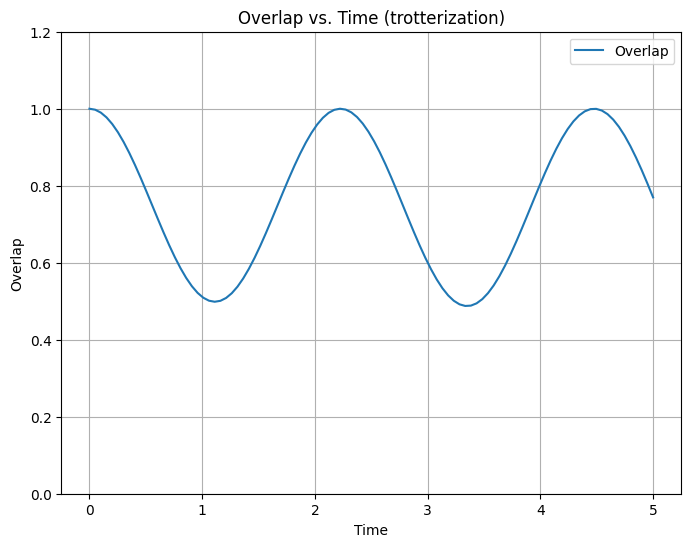

Final overlap: 0.7697217386597935


In [23]:


# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (trotterization)")
plt.grid()
plt.legend()
plt.show()

print("Final overlap:", overlaps[-1])



### Exact Evolution

In [24]:

overlaps = []
overlaps1 = [] #for symmetric state
sum_overlaps = []
correlations_exact = []

# Compute the overlap with initial state
for t in times:
    result = exact_evo(t)  
    #result = result.numpy()  # Convert to NumPy array if required
    
    overlap = np.vdot(initial_state, result) 
    overlap = np.abs(overlap)**2
    overlaps.append(overlap)

    overlap1 = np.vdot(symmetric_state, result) 
    overlap1 = np.abs(overlap1)**2
    overlaps1.append(overlap1)

    sum_overlap = overlap + overlap1
    sum_overlaps.append(sum_overlap)

    correlation_exact = correlation_function(0, 1, result)
    correlations_exact.append(correlation_exact)


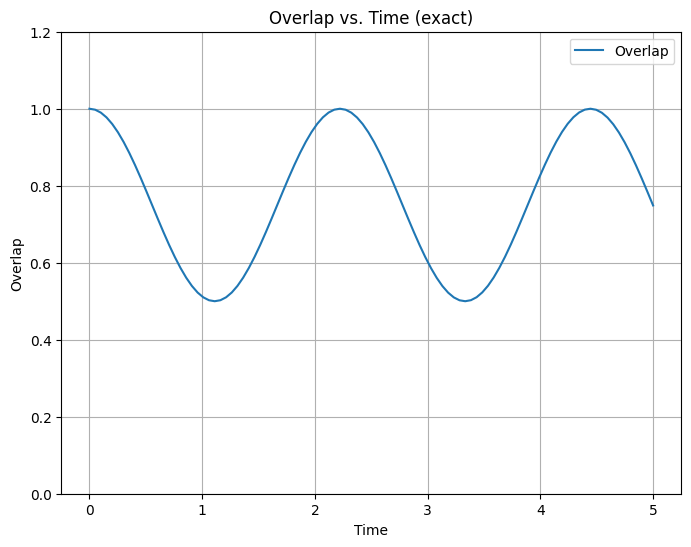

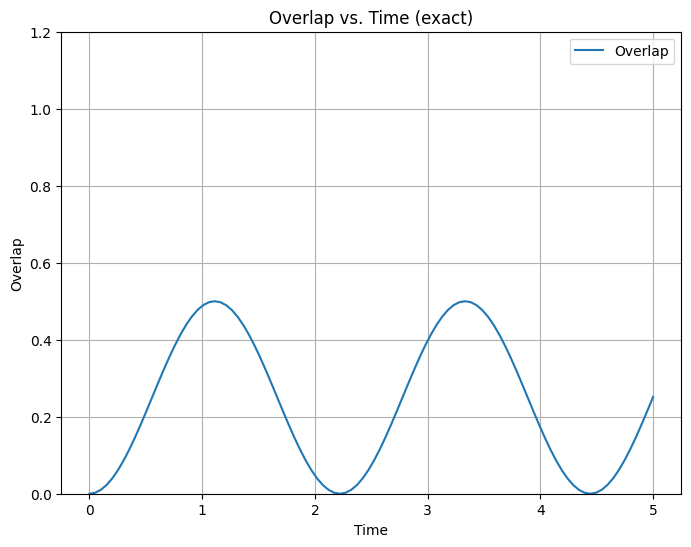

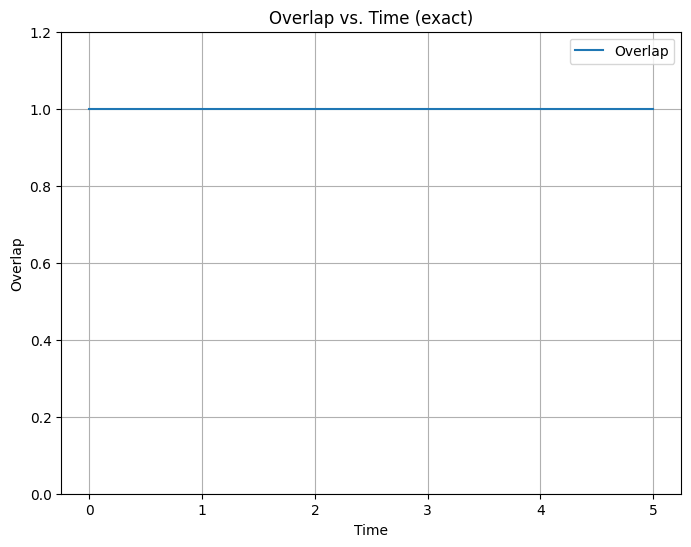

In [25]:

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps1, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, sum_overlaps, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()

### Error

In [26]:
probabilities = []

# compute overlap between exact and paper evolution
for t in times:
    evolved_state_exact = exact_evo(t)
    evolved_state_trotter = paper_evo(t, n_trotter_steps)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo
    
    overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    probability = np.abs(overlap)**2
    probabilities.append(probability)

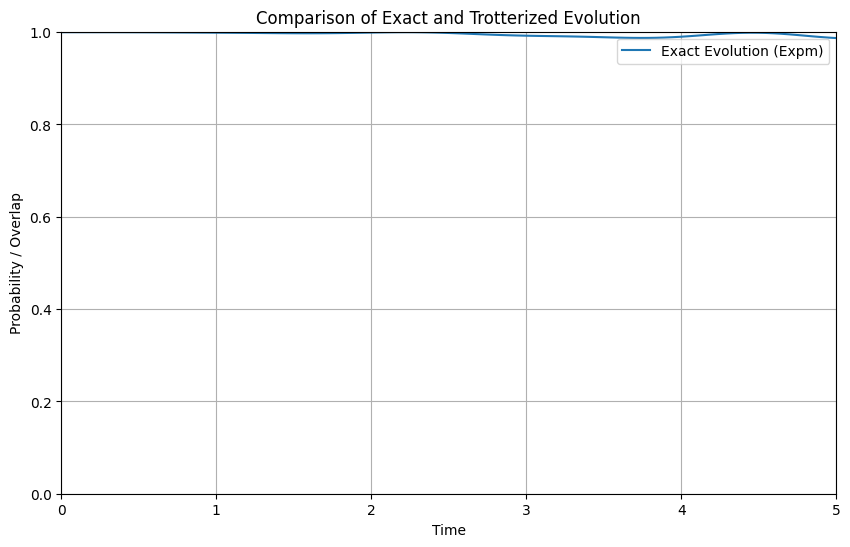

In [27]:
# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(times, probabilities, label="Exact Evolution (Expm)", markersize=3)
plt.xlabel("Time")
plt.ylabel("Probability / Overlap")
plt.xlim([0, t_max])
plt.ylim([0.0, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution")
plt.grid()
plt.legend()
plt.show()

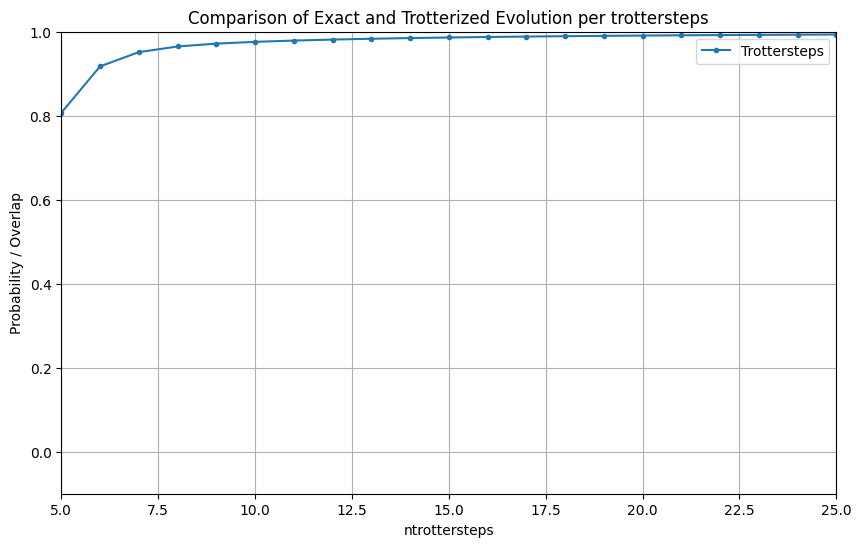

In [28]:

probabilities1 = []

min_trotter_step = 5
max_trotter_step = 25
trotter_steps = np.arange(min_trotter_step, max_trotter_step + 1)

# compute overlap between exact and paper evolution
for n in trotter_steps:
    evolved_state_exact = exact_evo(5)
    evolved_state_trotter = paper_evo(5, n)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo
    
    overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    probability = np.abs(overlap)**2
    probabilities1.append(probability)

# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(trotter_steps, probabilities1, label="Trottersteps", marker="o", markersize=3)
plt.xlabel("ntrottersteps")
plt.ylabel("Probability / Overlap")
plt.xlim([min_trotter_step, max_trotter_step])
plt.ylim([-0.1, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution per trottersteps")
plt.grid()
plt.legend()
plt.show()


/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


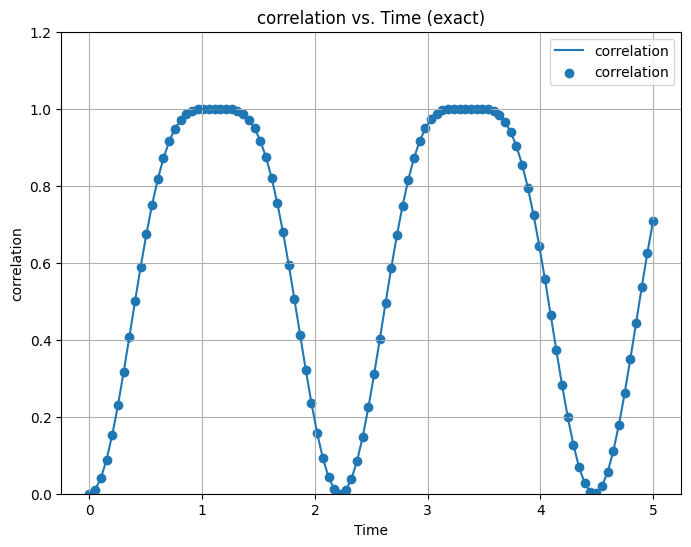

In [29]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, correlations_exact, label="correlation")
plt.scatter(times, correlations_trotter, label="correlation")
plt.xlabel("Time")
plt.ylabel("correlation")
plt.ylim([0, 1.2])
plt.title("correlation vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()

In [30]:

#checks for every inital state which one evolves
dim = 2**n_qubits
def get_initial_state(v):
    initial_state = np.zeros(dim, dtype=complex)
    initial_state[v] = 1
    return initial_state

print(initial_state.shape)

def exact_evo_all(t, v, H):
    initial_state=get_initial_state(v)
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t)) 
    evolved_state = U @ initial_state
    overlap=np.abs(np.vdot(evolved_state, initial_state))**2
    return overlap

for v in range(0,2**n_qubits):
    print(v, exact_evo_all(5, v, H1), exact_evo_all(5, v, H2), exact_evo_all(5, v, H))
    

(16,)
0 1.0 1.0 1.0
1 1.0 1.0 0.9999999999999996
2 1.0 1.0 0.9999999999999996
3 1.0 0.08046423546177364 0.7487578344668522
4 1.0 1.0 0.9999999999999996
5 1.0 1.0 1.0
6 1.0 1.0 1.0
7 1.0 1.0 1.0
8 1.0 1.0 0.9999999999999996
9 1.0 1.0 1.0
10 1.0 1.0 1.0
11 1.0 1.0 1.0
12 1.0 0.08046423546177367 0.7487578344668522
13 1.0 1.0 0.9999999999999993
14 1.0 1.0 0.9999999999999993
15 1.0 1.0 0.9999999999999993


### Extra

In [31]:
# dev = qml.device("default.qubit", wires=int(np.log2(H.shape[0])))
# @qml.qnode(dev)

# def pennylane_evo(t, n, v):
#     b=int(np.log2(H.shape[0]))
#     for i in range (0, b):
#         if v >= (2**(b-i-1)):
#             qml.PauliX(wires=(i))
#             v=v-2**(b-i-1)
#         # print(v)
#     qml.ApproxTimeEvolution(H_ps.hamiltonian(), t, n)
#     return qml.state()
